Anexo N

# Red Neuronal Convolucional EfficientNet

#### Elaborado por: Ricardo Niño de Rivera Barrón

#### Ingeniería Biónica

#### Trabajo Terminal II

En esta libreta interactiva se describe el proceso para la implementación de un modelo preentrenado de Red Neuronal Convolucional llamado EfficientNet.

Esta libreta se desarrolló en la plaforma Kaggle con el objetivo de mejorar la velocidad de implementación.

In [1]:
# Se instala una biblioteca con los modelos preentrenados EfficientNet
!pip install efficientnet

     |████████████████████████████████| 50 kB 2.7 MB/s 


In [2]:
# Llamamos a la biblioteca
import efficientnet.keras as efn

In [3]:
# Importando bibliotecas necesarias
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import matplotlib.image as mpimg
import sklearn
import tensorflow as tf

Ahora instalamos una nueva biblioteca para poder descargar archivos de MEGA.

In [4]:
# Instalanado mega.py
!pip install mega.py

     |████████████████████████████████| 49 kB 4.5 MB/s 
     |████████████████████████████████| 13.7 MB 9.3 MB/s 
  Created wheel for pathlib: filename=pathlib-1.0.1-py3-none-any.whl size=14346 sha256=50ca0bf248eda07557f750715c704bd81c50fcb1b254e258f470c35a4ea3380d
  Stored in directory: /root/.cache/pip/wheels/6e/96/b8/10037fe231e23970bac58361d7c93571ab983a7bbc55e68550
Successfully built pathlib
  Attempting uninstall: tenacity
    Found existing installation: tenacity 6.1.0
    Uninstalling tenacity-6.1.0:
      Successfully uninstalled tenacity-6.1.0


In [5]:
# De la biblioteca mega importamos el método Mega
from mega import Mega

In [6]:
# Instanciando Mega en el objeto mega
mega = Mega()

Inicamos sesión en MEGA con cuenta temporal y anónima

In [7]:
# Log in en la cuenta de MEGA con cuenta temporal anónima
m = mega.login()

Descargando Base de Datos.

In [8]:
# Descargando Base de Datos
m.download_url('https://mega.nz/file/dBARgAIQ#uiQq4P-zC1fm6tV1I_udl2dtCiqzwyDadLyVlZ_dzAY')

PosixPath('BaseDeDatosFrontales_FINAL_256_bits.zip')

Como Kaggle es un entorno de desarrollo que trabaja en Linux utilizaremos algunos comandos nativos de este sistema operativo.

Para descomprimir el archivo utilizarmos el comando nativo de Linux <em>unzip</em>.



In [9]:
!unzip -q BaseDeDatosFrontales_FINAL_256_bits.zip

Descargamos los archivos necesarios.



In [10]:
# Descargando pos_train
m.download_url('https://mega.nz/file/Fcp12QzD#MLUFNaNeKJ8YFPo2bO1uNt7hnKCbDAy8S10s1-vKJ5Q')

PosixPath('pos_train.npy')

In [11]:
# Descargando pos_test
m.download_url('https://mega.nz/file/sQoFDaRB#Uh70-XjrqlGKaE9eBoc4puXnNxNFcQ0D23h_79rDnC4')

PosixPath('pos_test.npy')

In [12]:
# Descargando Y_train2.npy
m.download_url('https://mega.nz/file/tdohXarb#SRrt31GIT7H6gioCVm2KYF-sH6a8PHK8Z7Tr76oZb4I')

PosixPath('Y_train2.npy')

In [13]:
# Descargando Y_test2.npy
m.download_url('https://mega.nz/file/Vc5TBSbY#D8pbUvpA3l2V0PJxCu7Meg8WJ3wPpT6X2jEoDsleCWw')

PosixPath('Y_test2.npy')

Ahora se leen los archivos con numpy

In [14]:
pos_train = np.load('pos_train.npy')
pos_train.shape

(3337,)

In [15]:
pos_test = np.load('pos_test.npy')
pos_test.shape

(832,)

In [16]:
Y_train = np.load('Y_train2.npy')
Y_train.shape

(3337,)

In [17]:
# Agregando un dimensión para evitar errores con tensorflow
#Y_train = np.expand_dims(Y_train, axis=1)
#Y_train.shape

In [18]:
Y_test = np.load('Y_test2.npy')
Y_test.shape

(832,)

In [19]:
# Agregando un dimensión para evitar errores con tensorflow
#Y_test = np.expand_dims(Y_test, axis=1)
#Y_test.shape

Leemos los archivos en los directorios de interés.

In [20]:
# Leyendo archivos de entrenamiento
files=os.listdir("./BaseDeDatosFrontales_FINAL_256_bits/train")

In [21]:
# Leyendo archivos de validación
files2=os.listdir("./BaseDeDatosFrontales_FINAL_256_bits/test")

In [22]:
# Ordenando alfabeticamente el contenido de las listas
files.sort()
files2.sort()

### Construyendo X_train y X_test

Vamos a definir un nuevo tamaño de las imágenes para evitar problemas de memoria y acelerar el entrenamiento.

In [23]:
size_img = 128

In [24]:
# Definiendo función get_img para leer los archivos numpy y ajustarlos a nuevo tamaño.
# La imagen que retorna la función también es normalizada sobre los valor máximo del pixel (255)
def get_img(path, size, display_image = False):
  img = np.load(path)
  img = np.expand_dims(img, axis=2)
  if display_image == True:
    print(img.shape)
    plt.imshow(img[:,:,0], cmap='hot')

  return tf.image.resize(img, [size,size], antialias=True)/255

In [25]:
# Directorio raíz
path = "./BaseDeDatosFrontales_FINAL_256_bits/"

Realizamos una prueba de funcionamiento de la función

(480, 640, 1)


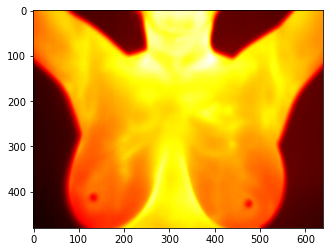

In [26]:
# Imagen original
hola=get_img(path+'train/'+files[1], size_img, display_image = True)

In [27]:
np.max(hola)

0.78683746

In [28]:
np.min(hola)

0.15518688

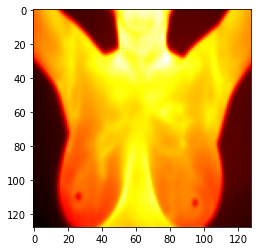

In [29]:
# Imagen resultante
plt.imshow(hola[:,:,0], cmap='hot')

Se leen los archivos y se ordenan en un nuevo arreglo.

In [30]:
# Entrenamiento X_train

# Creamos el arreglo para almacenar las imégenes
# Tendrá tres canales para  aprovechar los pesos preentrenados
# con imágenes de ImageNet
X_train = np.zeros((len(files), size_img, size_img,3))

for i in tqdm(range(len(files))):

  # Leemos y procesamos la imagen con respecto a pos_train
  temp_img = get_img(path+"train/"+files[pos_train[i]], size_img)

  # Almacenamos la imagen obtenida en cada canal
  X_train[i,:,:,0] = temp_img[:,:,0]
  X_train[i,:,:,1] = temp_img[:,:,0]
  X_train[i,:,:,2] = temp_img[:,:,0]

100%|██████████| 3337/3337 [00:18<00:00, 184.26it/s]


In [31]:
X_train.shape

(3337, 128, 128, 3)

In [32]:
# Validación X_test

# Creamos el arreglo para almacenar las imégenes
# Tendrá tres canales para  aprovechar los pesos preentrenados
# con imágenes de ImageNet
X_test = np.zeros((len(files2), size_img, size_img,3))

for i in tqdm(range(len(files2))):

  # Leemos y procesamos la imagen con respecto a pos_train
  temp_img = get_img(path+"test/"+files2[pos_test[i]], size_img)

  # Almacenamos la imagen obtenida en cada canal
  X_test[i,:,:,0] = temp_img[:,:,0]
  X_test[i,:,:,1] = temp_img[:,:,0]
  X_test[i,:,:,2] = temp_img[:,:,0]

100%|██████████| 832/832 [00:06<00:00, 131.97it/s]


In [33]:
X_test.shape

(832, 128, 128, 3)

### EfficientNet

En esta sección se implementa la arquitectura EfficientNet.

La arquitectura EfficientNet fue propuesta en 2019 como una alternativa para manipular tres parámetros que empíricamente se ha observado influyen en modelos reconocedores de imágenes. Estos son la resolución de la imagen de entrada, la profundidad de la red y el número de canales.

Los experimentos con diferentes aqruitecturas mencionan que una resolución alta combinada con número de cánales grande mejoran la capacidad del modelo para hallar detalles en la imagen, sin embargo esto no es necesarimante independiente de la profuncidad de la red neuronal y hallar esta relación no es una tarea trivial ni rápida. Ya que es posible alterar la resolución no solo de la umagen de entrada sino las salidas de cada convolución así como el número de canales resultante. 

La arquitectura EffcientNet es un modelo específico que se utilizó para aplicar el método que resuleve el problema de encontrar "la mejor" correlación de estos tres parámetros con el número de Flops (operaciones de punto flotante). Para esto lo autores proponen un parámetro *phi* que indica la potencia a la que se elevan tres constantes (que minimicen el número de FLOPS necesarios) llamadas *alpha* (relacionado a la resolución), *betha* (relacionado a los canales) y *gamma* (relacionado a la profundidad). Esto simplifica el proceso de "sintonización" de los tres parámetros y desmottraron mejores resultados que sus propuestas contemporáneas.

Esta método no es exclusivo de la arquitectura EfficentNet, es posible aplicar este principio a un sin número de arquitecturas, algunas de ellas fueron documentadas por los autores en la publicación original de 2019. Sin emabrgo, también desmotraron que la arquitectura EfficientNet superaba a la mayoría de los modelos existentes, con excepción de un "super" modelo que a pesar de contar con una cantidad ocho (8) veces más grande de parámetros su rendimiento fue "ligeramente" mayor a la EfficientNEt a un costo computacional seis (6) veces mayor. 

Los autores prueban ocho diferentes valores para el parámetro *phi* (0,1,2,...,7), resultando la EfficientNet7 (7 por el valor de *phi*) como la que mejor rencimiento en la métrica exactitud mostró en diferentes base de datos clásicas ref: https://arxiv.org/pdf/1905.11946.pdf

In [34]:
# importando bibliotecas auxiliares
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
import tensorflow_addons as tfa
from tensorflow.keras import Model, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [35]:
# Importando métricas de scikit learn}
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, accuracy_score

In [36]:
# Arreglando el problema de clases desbalanceadas estableciendo un peso por clase en el función de costo
w_p=np.sum(Y_train==0)/Y_train.shape[0]
w_n=np.sum(Y_train==1)/Y_train.shape[0]

In [37]:
# Creando diccionario para establecer el peso de cada clase de salida
class_weights = { 0 : w_n , 1 : w_p }

In [38]:
# definimos dropout
# Esta factor que está definido entre 0 y 1
# es un factor que determina la tasa de unidades que se "apagarán"
# durante el entrenamiento; esto evita el sobreajuste
dropout = 0.2

In [39]:
# Definimos un modelo de incialización
# Esta inicialización ha demostrado ser bastante útil
# para ayudar al modelo a converger más rápido.
# Incialización por he es una técnica que utiliza la destribución probabílistica
# propuesta por He para incializar los pesos de la red neuronal
# Para más información refierase a la coumentación
# de la biblioteca
kernel_init = 'he_normal'

In [40]:
# Creando el modelo EfficientNet con pesos preentrenados en ImageNet
rnet = efn.EfficientNetB7(weights='imagenet', include_top=False, input_shape=[X_train.shape[1],X_train.shape[2],X_train.shape[3]])
rnet = tf.keras.Sequential(rnet)
rnet.add(Dropout(dropout))
rnet.add(Flatten())
rnet.add(Dense(4096, activation='relu', kernel_initializer=kernel_init))
rnet.add(Dropout(dropout))
rnet.add(Dense(4096, activation='relu', kernel_initializer=kernel_init))
rnet.add(Dropout(dropout))
rnet.add(Dense(1, activation='sigmoid', kernel_initializer=kernel_init))

258441216/258434480 [==============================] - 3s 0us/step


In [41]:
# # Creando el modelo EfficientNet con pesos preentrenados en ImageNet
# rnet = efn.EfficientNetB7(weights=None, include_top=True, classes=1, input_shape=[X_train.shape[1],X_train.shape[2],X_train.shape[3]])
# rnet = tf.keras.Sequential(rnet)

In [42]:
# Visualizando el modelo
rnet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Functional) (None, 4, 4, 2560)        64097680  
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 2560)        0         
_________________________________________________________________
flatten (Flatten)            (None, 40960)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              167776256 
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_2 (Dropout)          (None, 4096)              0

In [43]:
rnet.output.shape

TensorShape([None, 1])

In [44]:
# Añadiendo un término de regularización para evitar sobreajuste

#L1 = 0.1

#regularizer = tf.keras.regularizers.L1(l1=L1)

#rnet.trainable = True

#for layer in rnet.layers:
#    for attr in ['kernel_regularizer']:
#        if hasattr(layer, attr):
#          setattr(layer, attr, regularizer)

In [45]:
# Se fuerza a la tasa de aprendiza a decaer de forma polinomial para evitar problemas con el entrenamiento
starter_learning_rate = 0.1
end_learning_rate = 0.01
decay_steps = 5
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=0.5)

In [46]:
# Definimos el optimizador utilizando el método de Adam
# Este método es una modificación del algoritmo de
# gradiente descendiente
opt=tfa.optimizers.RectifiedAdam(learning_rate=0.01) #,clipvalue=5)
#opt=tf.keras.optimizers.Nadam(learning_rate=0.01 ,clipvalue=5)
#opt=tf.keras.optimizers.Adam(learning_rate=learning_rate_fn) #,clipvalue=5)

In [47]:
# Definiendo las métricas necesarias para dar seguimiento al modelo
METRICS = [
  tf.keras.metrics.BinaryAccuracy(name='accuracy'),
  tf.keras.metrics.Precision(name='precision'),
  tf.keras.metrics.Recall(name='recall'),
  tfa.metrics.F1Score(num_classes=2, average="micro", threshold=0.5),
  tf.keras.metrics.AUC(name='AUC')
]

In [48]:
# Compilando el modelo
rnet.compile(
    optimizer=opt,
    loss = 'binary_crossentropy',
    metrics=METRICS
)

La métrica de oro será el AUC.



In [49]:
# Con este objeto se guardará el mejor modelo con base a la métrica f1_score
sv = tf.keras.callbacks.ModelCheckpoint(filepath='EFNB7_weights.h5',monitor='val_AUC', verbose=0, save_best_only=True,
        save_weights_only=False, mode='max', save_freq='epoch')

In [50]:
# Tamaño del batch (se recomienda un batch potencia de 2)
BS = 32

In [51]:
# Entrenando el modelo y almacenando los valores en history_1
history_1 = rnet.fit(X_train, Y_train, batch_size=BS,
                          steps_per_epoch=len(X_train) // BS, validation_data=(X_test, Y_test),
                          epochs=200, verbose=2, class_weight=class_weights, callbacks=[sv])

Epoch 1/200
104/104 - 84s - loss: 2.1471 - accuracy: 0.6055 - precision: 0.2493 - recall: 0.5890 - f1_score: 0.3503 - AUC: 0.6281 - val_loss: 479.9479 - val_accuracy: 0.7224 - val_precision: 0.5000 - val_recall: 0.0043 - val_f1_score: 0.0086 - val_AUC: 0.4989
Epoch 2/200
104/104 - 90s - loss: 0.2511 - accuracy: 0.6620 - precision: 0.3024 - recall: 0.6639 - f1_score: 0.4155 - AUC: 0.7304 - val_loss: 1.1267 - val_accuracy: 0.8462 - val_precision: 0.8992 - val_recall: 0.5022 - val_f1_score: 0.6444 - val_AUC: 0.8968
Epoch 3/200
104/104 - 65s - loss: 0.1151 - accuracy: 0.8557 - precision: 0.5639 - recall: 0.8687 - f1_score: 0.6839 - AUC: 0.9303 - val_loss: 0.4457 - val_accuracy: 0.8329 - val_precision: 1.0000 - val_recall: 0.3983 - val_f1_score: 0.5697 - val_AUC: 0.8924
Epoch 4/200
104/104 - 65s - loss: 0.1414 - accuracy: 0.8796 - precision: 0.6135 - recall: 0.8977 - f1_score: 0.7289 - AUC: 0.9478 - val_loss: 1.1780 - val_accuracy: 0.7416 - val_precision: 0.5222 - val_recall: 0.8139 - val_f

In [52]:
# Primera iteración con el AUC de validación más alto
best_iter=np.where(np.max(history_1.history['val_AUC'])==history_1.history['val_AUC'])[0][0]
print(best_iter)

1


In [53]:
# AUC más alto
history_1.history['val_AUC'][best_iter]

0.8968493938446045

In [54]:
# Definiendo la función para desplegar la curva ROC
def plot_roc(name, labels, predictions, name_fig):
    fp, tp, _ = roc_curve(labels, predictions)
    auc1 = auc(fp, tp)
    lw=2

    plt.plot(100*fp, 100*tp, linewidth=2, lw=lw, color='darkorange', label='ROC curve (area = %0.2f)' % auc1)
    plt.plot([0, 100], [0, 100], color='navy', lw=lw, linestyle='--',label='Random')
    plt.xlabel('Falsos positivos [%]')
    plt.ylabel('Verdaderos positivos [%]')
    plt.xlim([-5,105])
    plt.ylim([-5,105])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(name)
    plt.legend(loc="lower right")
    plt.savefig('ROC_'+name_fig+'.png')

In [55]:
# Definiendo función para visualizar curvas de entrenamiento
def display_training_curves(training, validation, title, subplot):   ####2
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('Iteración')
    ax.legend(['Entrenamiento', 'Validación.'])
    ax.scatter(best_iter, validation[best_iter], c='#ff7f0e', s=500)
    bbox = dict(boxstyle="round", fc="0.9")
    ax.annotate("Iteración con AUC más alto", (best_iter, validation[best_iter]), bbox=bbox)
    plt.savefig(str(title)+'.png')

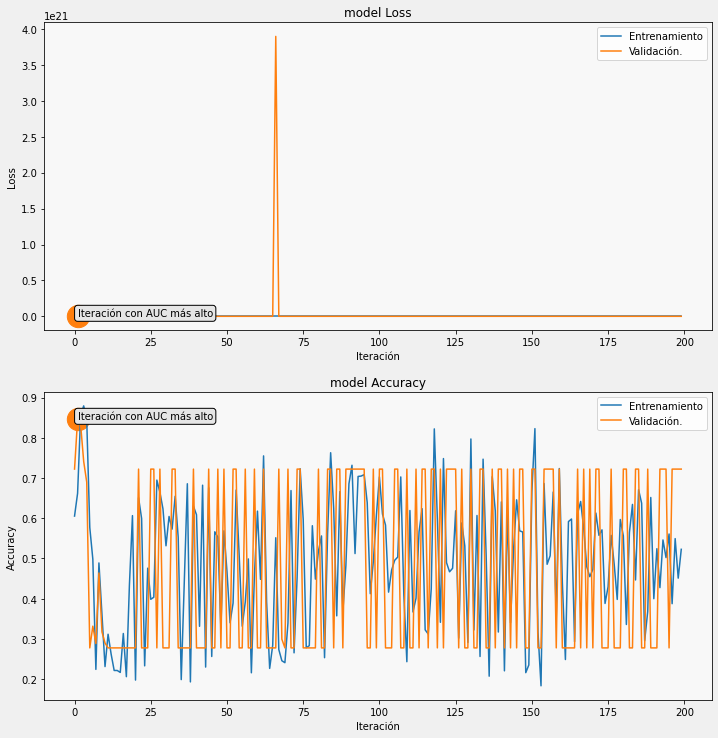

In [56]:
# Desplegando curvas (loss & accuracy)
display_training_curves(history_1.history['loss'], history_1.history['val_loss'], 'Loss', 211)
display_training_curves(history_1.history['accuracy'], history_1.history['val_accuracy'], 'Accuracy', 212)

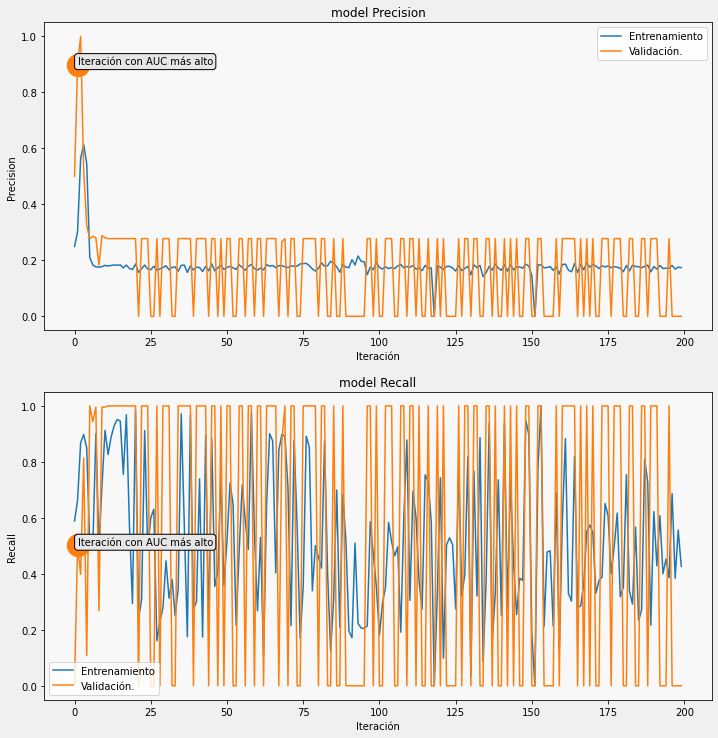

In [57]:
# Desplegando curvas (precision & recall)
display_training_curves(history_1.history['precision'], history_1.history['val_precision'], 'Precision', 211)
display_training_curves(history_1.history['recall'], history_1.history['val_recall'], 'Recall', 212)

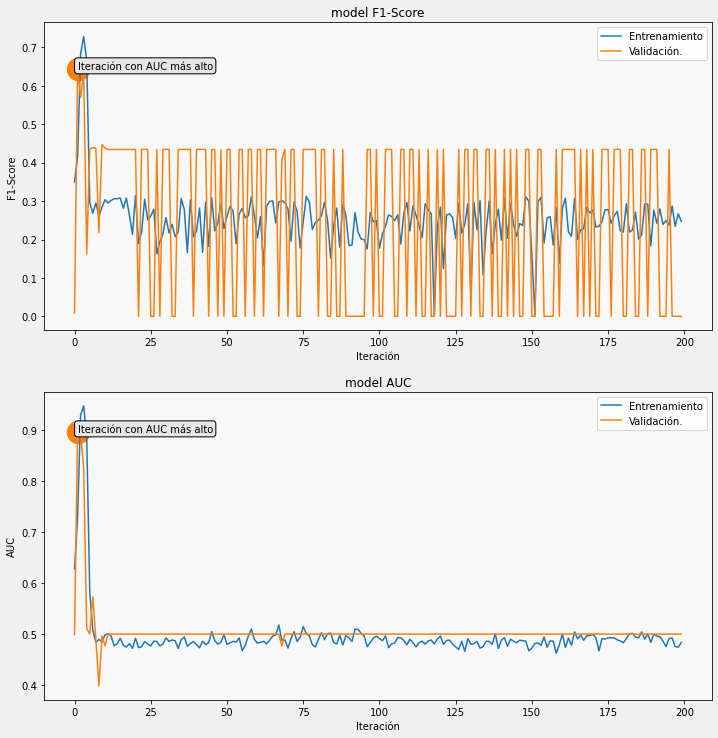

In [58]:
# Desplegando curvas (f1_score & AUC)
display_training_curves(history_1.history['f1_score'], history_1.history['val_f1_score'], 'F1-Score', 211)
display_training_curves(history_1.history['AUC'], history_1.history['val_AUC'], 'AUC', 212)

In [59]:
# Cargamos el modelo con la mejor métrica de AUC en validación
rnet.load_weights("EFNB7_weights.h5")

In [60]:
# Calculando las predicciones para Red Neuronal
Y_train_pred = (rnet.predict(X_train) > 0.5).astype("int32")
Y_train_proba = rnet.predict(X_train) # Arreglo de probabilidades
Y_test_pred = (rnet.predict(X_test) > 0.5).astype("int32")
Y_test_proba = rnet.predict(X_test) # Arreglo de probabilidades

Lamentablemente Tensorflow subestima la métrica F1-Score y Sobrestima la métrica AUC. Para este trabajo se reportarán los resultados con base en la biblioteca de Scikit-Learn y se utilizará las métricas de TensorFlow sólo como auxiliar para hallar el valor más alto ponderado durante las iteracion o entrenamiento.

Por tanto es posible que algunas gráficas del entrenamiento difieran con los resultados finales de estas dos métricas.

A continuación de realiza una demostración de lo anteriromente descrito.




In [61]:
# Desplegando métrica del rendimiento
print("ResNet50 TensorFlow Metrics")
print()
print("MÉTRICAS EN ENTRENAMIENTO")
metric = tf.keras.metrics.BinaryAccuracy()
metric.update_state(Y_train, Y_train_pred)
print("Accuracy: %0.2f%%"%(100*metric.result().numpy()))
metric = tf.keras.metrics.Precision()
metric.update_state(Y_train, Y_train_pred)
print("Precision: %0.2f%%"%(100*metric.result().numpy()))
metric = tf.keras.metrics.Recall()
metric.update_state(Y_train, Y_train_pred)
print("Recall: %0.2f%%"%(100*metric.result().numpy()))
metric = tfa.metrics.F1Score(num_classes=2, average="micro", threshold=0.5)
metric.update_state(Y_train, Y_train_pred)
print("F1-Score: %0.2f%%"%(100*metric.result().numpy()))
metric = tf.keras.metrics.AUC()
metric.update_state(Y_train, Y_train_proba)
print("AUC: %0.2f%%"%(100*metric.result().numpy()))
print()
print("MÉTRICAS EN VALIDACIÓN")
metric = tf.keras.metrics.BinaryAccuracy()
metric.update_state(Y_test, Y_test_pred)
print("Accuracy: %0.2f%%"%(100*metric.result().numpy()))
metric = tf.keras.metrics.Precision()
metric.update_state(Y_test, Y_test_pred)
print("Precision: %0.2f%%"%(100*metric.result().numpy()))
metric = tf.keras.metrics.Recall()
metric.update_state(Y_test, Y_test_pred)
print("Recall: %0.2f%%"%(100*metric.result().numpy()))
metric = tfa.metrics.F1Score(num_classes=2, average="micro", threshold=0.5)
metric.update_state(Y_test, Y_test_pred)
print("F1-Score: %0.2f%%"%(100*metric.result().numpy()))
metric = tf.keras.metrics.AUC()
metric.update_state(Y_test, Y_test_proba)
print("AUC: %0.2f%%"%(100*metric.result().numpy()))
print()
print()
print("ResNet50 SciKit-Learn Metrics")
print()
print("MÉTRICAS EN ENTRENAMIENTO")
print("Accuracy: %0.2f%%"%(100*accuracy_score(Y_train, Y_train_pred)))
print("Precision: %0.2f%%"%(100*precision_score(Y_train, Y_train_pred)))
print("Recall: %0.2f%%"%(100*recall_score(Y_train, Y_train_pred)))
print("F1-Score: %0.2f%%"%(100*f1_score(Y_train, Y_train_pred)))
fp, tp, _ = roc_curve(Y_train, Y_train_proba)
print("AUC: %0.2f%%"%(100*auc(fp, tp)))
print()
print("MÉTRICAS EN VALIDACIÓN")
print("Accuracy: %0.2f%%"%(100*accuracy_score(Y_test, Y_test_pred)))
print("Precision: %0.2f%%"%(100*precision_score(Y_test, Y_test_pred)))
print("Recall: %0.2f%%"%(100*recall_score(Y_test, Y_test_pred)))
print("F1-Score: %0.2f%%"%(100*f1_score(Y_test, Y_test_pred)))
fp, tp, _ = roc_curve(Y_test, Y_test_proba)
print("AUC: %0.2f%%"%(100*auc(fp, tp)))
print()

ResNet50 TensorFlow Metrics

MÉTRICAS EN ENTRENAMIENTO
Accuracy: 87.71%
Precision: 73.19%
Recall: 50.33%
F1-Score: 14.70%
AUC: 87.13%

MÉTRICAS EN VALIDACIÓN
Accuracy: 84.62%
Precision: 89.92%
Recall: 50.22%
F1-Score: 19.90%
AUC: 89.68%


ResNet50 SciKit-Learn Metrics

MÉTRICAS EN ENTRENAMIENTO
Accuracy: 87.71%
Precision: 73.19%
Recall: 50.33%
F1-Score: 59.65%
AUC: 90.83%

MÉTRICAS EN VALIDACIÓN
Accuracy: 84.62%
Precision: 89.92%
Recall: 50.22%
F1-Score: 64.44%
AUC: 90.24%



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  import sys


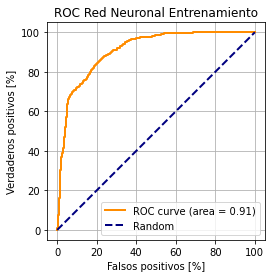

In [62]:
# Curva ROC de entrenamiento
plot_roc('ROC Red Neuronal Entrenamiento', Y_train, Y_train_proba, name_fig='RNET')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  import sys


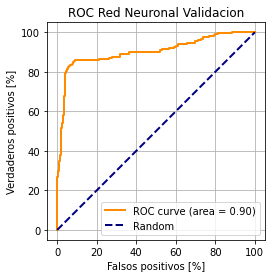

In [63]:
# Curva de Roc de Validación
plot_roc('ROC Red Neuronal Validacion', Y_test, Y_test_proba, name_fig='RNET2')

Finalmente se guarda el modelo completo.

In [64]:
rnet.save('EFNB7_FULL.h5')

Eliminando archivos innecesarios para guardar la libreta en Kaggle

In [65]:
import shutil

dir_path = './BaseDeDatosFrontales_FINAL_256_bits'

try:
    shutil.rmtree(dir_path)
except OSError as e:
    print("Error: %s : %s" % (dir_path, e.strerror))

In [66]:
os.remove("./BaseDeDatosFrontales_FINAL_256_bits.zip")